# Optimization problems

## Calculating large Fibonacci numbers

Say we want to calculate the millionth Fibonacci number. The classical algorithm for calculating the nth Fibonacci number, taught in most introductory computer science courses, is as follows:

In [1]:
def fib(n):
    """Calculates the nth Fibonacci number"""
    a, b = 0, 1
    while n > 0:
        a, b = b, a + b
        n -= 1

    return a

Note that this algorithm treats 0 as the 0th Fibonacci number and will only handle positive values for n. (Mathematicians sometimes count 0 as the first Fibonacci number. This is known as the combinatorial definition. But counting from 0 is more traditional and works better if you want to accommodate negative values of n.)

Since we know that `fib(n + 2) = fib(n) + fib(n + 1)`, we can solve for `fib(n)` to get `fib(n) = fib(n + 2) - fib(n + 1)`, and we can use this solution to extend our classical Fibonacci algorithm to accommodate negative values of n:

In [2]:
def fib(n):
    """Calculates the nth Fibonacci number"""
    a, b = 0, 1
    while n > 0:
        a, b = b, a + b
        n -= 1
    while n < 0:
        a, b = b - a, a
        n += 1
    return a

for n in range(-5,6):
    print(fib(n), end=" ")

5 -3 2 -1 1 0 1 1 2 3 5 

Note that the Fibonacci numbers for negative values of n have the same absolute values as the Fibonacci numbers for corresponding positive values of n. However, they are negative when n is even, but positive when n is odd. Thus, `fib(-1) == 1`, but `fib(-2) == -1`. We could, of course, use this heuristic in our algorithm, but there's no efficiency gain from doing so.

This classical algorithm for calculating the nth Fibonacci number takes approximately O(n^2) time, or quadratic time, because of the increasing computational burden of large-number arithmetic for high values of n. The number of digits in the nth Fibonacci number is linearly related to n, as we can confirm by plotting n against the number of digits, as shown below.

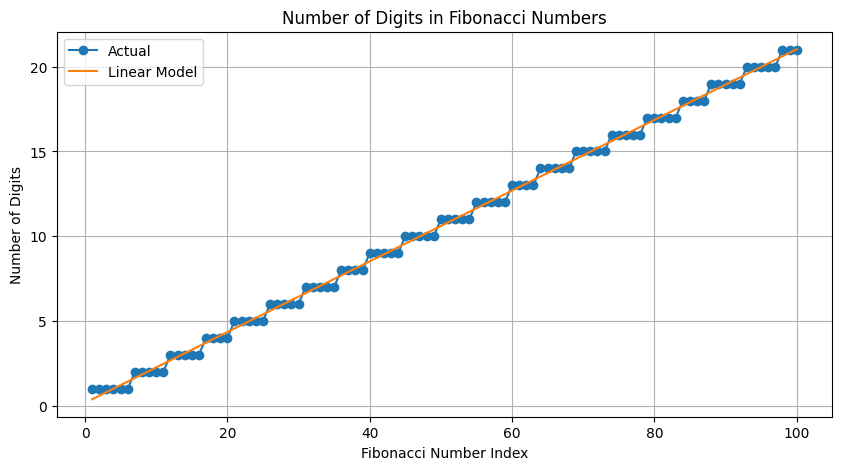

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Calculate the first 100 Fibonacci numbers
fibonacci_numbers = [fib(i) for i in range(1, 101)]

# Get the number of digits in each Fibonacci number
num_digits = [len(str(num)) for num in fibonacci_numbers]

# Define the linear model function
def linear_model(x, a, b):
    return a * x + b

# Fit the linear model
x_data = np.arange(1, 101)
popt_linear, _ = curve_fit(linear_model, x_data, num_digits)

# Generate points for the fitted model
x_fit = np.linspace(1, 100, 100)
y_fit_linear = linear_model(x_fit, *popt_linear)

# Plotting the number of digits and fitted model
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), num_digits, marker='o', label='Actual')
plt.plot(x_fit, y_fit_linear, label='Linear Model')
plt.title('Number of Digits in Fibonacci Numbers')
plt.xlabel('Fibonacci Number Index')
plt.ylabel('Number of Digits')
plt.legend()
plt.grid(True)
plt.show()

Thus, the algorithm requires O(n) iterations to reach the nth Fibonacci number, and each iteration involves an addition operation with numbers of size O(n). Assuming a standard arithmetic algorithm where the time complexity of adding two numbers is proportional to the number of digits, each addition operation takes O(n) time. Therefore, the total time complexity of the algorithm is O(n^2), resulting from O(n) iterations, each with an O(n) time complexity for the addition operation. (In practice, it may be closer to O(n*log(n)) due to the efficiency of Python's underlying algorithms for large-number arithmetic.)

Let's check our intuitions about time complexity:

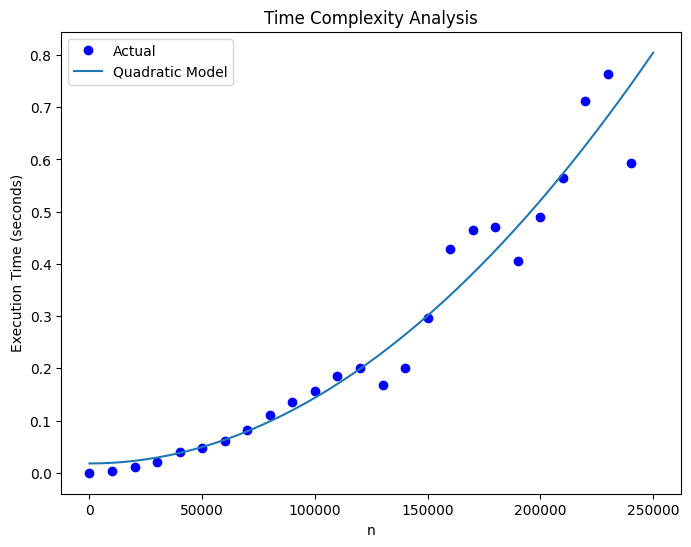

In [4]:
import timeit
from scipy.optimize import curve_fit

def test_time_complexity(fib_func, n_values, num_runs=3):
    """
    Tests the time complexity of the Fibonacci function.
    
    Args:
        fib_func (function): The Fibonacci function to test.
        n_values (list): A list of n values to test.
        num_runs (int): The number of times to run each test case (default=3).
    
    Returns:
        A list of tuples containing the n value and the average execution time.
    """
    results = []
    for n in n_values:
        stmt = f"{fib_func.__name__}({n})"
        setup = f"from __main__ import {fib_func.__name__}"
        execution_time = timeit.timeit(stmt, setup, number=num_runs)
        avg_time = execution_time / num_runs
        results.append(avg_time)
    return results

# Test the time complexity
n_values = list(range(0, 250000, 10000))
exec_times = test_time_complexity(fib, n_values, 10)

# Define the linear model function
def quadratic_model(x, a, b):
    return a * x**2 + b

# Fit the linear model
popt_quadratic, _ = curve_fit(quadratic_model, n_values, exec_times)

# Generate points for the fitted models
x_fit = np.linspace(1, 250000)
y_fit_quadratic = quadratic_model(x_fit, *popt_quadratic)

# Plot the results and fitted models
plt.figure(figsize=(8, 6))
plt.plot(n_values, exec_times, 'bo', label='Actual')
plt.plot(x_fit, y_fit_quadratic, label='Quadratic Model')
plt.xlabel('n')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.title('Time Complexity Analysis')
plt.show()

As expected, our analysis shows that this algorithm takes quadratic time.

Fortunately, Fibonacci numbers have mathematical properties we can take advantage of to complete the calculation faster. Let's look at two such approaches.

### 1. Calculating Fibonacci numbers using Binet's formula

For our first solution, we can take advantage of the rule that `fib(n)` for any positive value of n is the closest integer to `(Φ**n)/sqrt(5)`, where `Φ = (1+sqrt(5))/2` (an irrational constant known as the "Golden Ratio"). This rule is a simplified version of "Binet's Formula" (see [this proof](https://www.cut-the-knot.org/proofs/BinetFormula.shtml) of the full formula).

Note that by default, Python's double-precision `float` type is accurate only to about 15 decimal digits. This is inadequate for precision with numbers as large as we want to calculate, so we have to use Python's `Decimal` type. To determine the necessary precision, we can use an approximation of the formula for calculating the number of digits from the linear model we trained above.

Since the version of Binet's Formula we're using only applies to positive numbers, we can also now take advantage of our observation, above, that Fibonacci numbers for negative values of n are negative when n is even, but positive when n is odd. (There's a more complex version of Binet's formula we could use, but the even-odd heuristic saves us a bit of computation time vs. that formula.)

In [5]:
from decimal import Decimal, getcontext
from math import ceil

def fib(n):
    """Calculates the nth Fibonacci number"""
    if n < 0 and n % 2 == 0:
        sign, n = -1, abs(n)
    else:
        sign, n = 1, abs(n)
    
    # Not shown: I trained a linear model to determine necessary precision
    getcontext().prec = ceil(0.21*n + 5)
    
    # Use Binet's formula to calculate nth fib
    sqrt_5 = Decimal(5).sqrt()
    dec_n = Decimal(n)
    phi = (Decimal(1) + sqrt_5) / Decimal(2)
    fib_n = (phi**dec_n) / sqrt_5

    return sign*round(fib_n)

Presumably we're now completing the calculation in approximately O(n), or linear, time complexity (since the number of digits required for the operation scales linearly with n). Let's check that intuition:

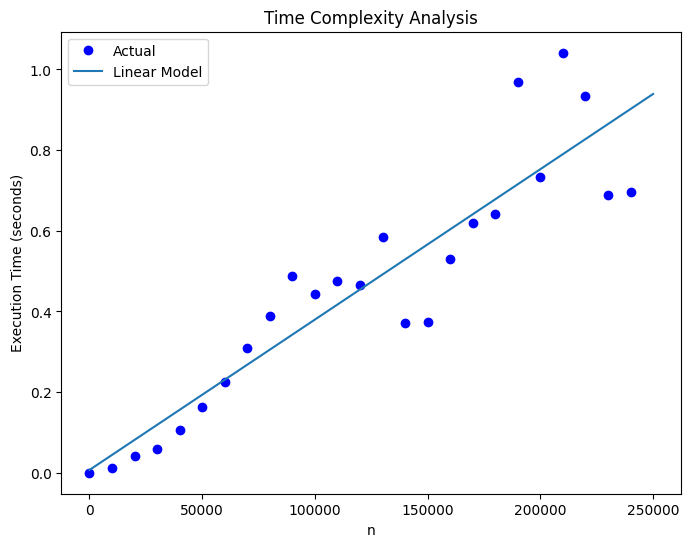

In [6]:
# Test the time complexity
n_values = list(range(0, 250000, 10000))
exec_times = test_time_complexity(fib, n_values, 10)

# Define the linear model function
def linear_model(x, a, b):
    return a * x + b

# Fit the linear model
popt_linear, _ = curve_fit(linear_model, n_values, exec_times)

# Generate points for the fitted models
x_fit = np.linspace(1, 250000)
y_fit_linear = linear_model(x_fit, *popt_linear)

# Plot the results and fitted models
plt.figure(figsize=(8, 6))
plt.plot(n_values, exec_times, 'bo', label='Actual')
plt.plot(x_fit, y_fit_linear, label='Linear Model')
plt.xlabel('n')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.title('Time Complexity Analysis')
plt.show()

Sure enough, it looks like this is a linear time algorithm and will outperform the classical algorithm for values of n greater than about 250,000.

### 2. Calculating Fibonacci numbers using matrix exponentiation

A second approach performs even better, allowing us to calculate the nth Fibonacci number in O(log(n)) time complexity (and with far fewer lines of code). This approach is based on the "matrix exponentiation" formula (see [this proof](https://math.stackexchange.com/a/784723)) for calculating Fibonacci numbers—that is, the observation that, for positive values of n:

```
[[1, 1], [1, 0]]**n = [[f(n+1), f(n)], [f(n), f(n-1)]]
```

In other words, when you raise a 2x2 matrix with the values `1, 1; 1, 0` to the nth power, the nth Fibonacci number will be in the upper right position in the resulting matrix. The "binary exponentiation algorithm" for matrix multiplication takes O(log(n)) time, making this operation very efficient.

For negative values of n, we replace 1 with -1 in the upper left position of the transformation matrix and raise the matrix to the absolute-value-of-n power.

In [7]:
from numpy import matrix

def fib(n):
    return (
            matrix(
                '1 1; 1 0' if n >= 0 else '-1 1; 1 0',
            ) ** abs(n) # Raise matrix to absolute value of n power
        )[0, 1] # Return the number in the 0th row, 1st column

Let's confirm that this is taking O(log(n)) time complexity:

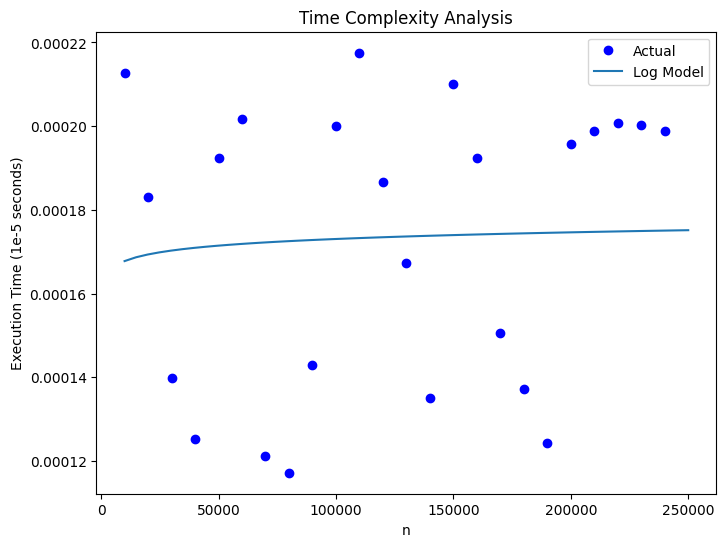

In [8]:
# Test the time complexity
n_values = list(range(10000, 250000, 10000))
exec_times = test_time_complexity(fib, n_values, 50000)

# Define the linear model function
def log_model(x, a, b):
    return a * np.log(x) + b

# Fit the linear model
popt_log, _ = curve_fit(log_model, n_values, exec_times)

# Generate points for the fitted models
x_fit = np.linspace(10000, 250000)
y_fit_log = log_model(x_fit, *popt_log)

# Plot the results and fitted models
plt.figure(figsize=(8, 6))
plt.plot(n_values, exec_times, 'bo', label='Actual')
plt.plot(x_fit, y_fit_log, label='Log Model')
plt.xlabel('n')
plt.ylabel('Execution Time (1e-5 seconds)')
plt.legend()
plt.title('Time Complexity Analysis')
plt.show()

We more or less confirm our expectation, although this operation is *so* blazingly fast that our time measurement is mostly noise, and we have to repeat the operation ten thousand times for each value of n to get a meaningful result!

(To be honest, I'm completely blown away by the speed of this calculation. It's one thing to read in a book that this is the fastest approach, and another thing to actually see the performance on a benchmark. Clearly I need to master matrix math, because it's an incredible tool.)

## Optimizing nested loops

Let's say we have this function:

v(k,n) = 1 / (k × (n+1)²ᵏ)

And we want to be able to sum the results for all values 1 to K and 1 to N for arbitrary values of K and N:

S(K,N) = ∑ₖ₌₁ᴷ u(k,N) = ∑ₖ₌₁ᴷ (∑ₙ₌₁ᴺ v(k,n))

This poses a challenging optimization problem because of the need for nested calculations, which gives us O(N*K) time complexity.

Let's measure the execution time of a naïve implementation using nested `for` loops:

In [9]:
import time

def nested_loops(maxk, maxn):
    result = 0
    for k in range(1, maxk+1):
        for n in range(1, maxn+1):
            result += 1/(k*(n+1)**(2*k))
    return result

# Set small values for maxk and maxn
small_maxk = 300
small_maxn = 300

# Set large values for maxk and maxn
large_maxk = 1000
large_maxn = 1000

# Test nested_loops for small K and N
start_time = time.time()
result_nested_loops = nested_loops(small_maxk, small_maxn)
print(result_nested_loops)
end_time = time.time()
print(f"Time taken using nested loops with small K and N: {end_time - start_time:.5f} seconds")

# Test nested_loops for large K and N
start_time = time.time()
result_nested_loops = nested_loops(large_maxk, large_maxn)
print(result_nested_loops)
end_time = time.time()
print(f"Time taken using nested loops with large K and N: {end_time - start_time:.5f} seconds")

0.6898304279339494
Time taken using nested loops with small K and N: 0.33188 seconds
0.69214867823035
Time taken using nested loops with large K and N: 26.27671 seconds


With `for` loops, we need about 14 seconds to calculate S(1000, 1000). This is the time to beat.

### Are nested `for` loops meaningfully slower than `map` or `reduce`?

Let's compare implementations using `map`, `itertools.product`, or `functools.reduce`, because these are implemented in C and are generally considered to be faster than Python `for` loops.

My instinct is that `map` and `itertools.product` might be a little slower than `reduce`, because these implementations require moving around more bits in memory to create intermediate data structures. `map` is designed to take an an input of length `n` and return an output of length `n`. That means we're storing intermediate results in a fairly large iterable, and we then have to sum across the iterable to output our final result as a float. The same is true of `itertools.product`: it emits an iterable of `n` length, which we have to sum over.

In contrast, both our `for` loop implementation and `functools.reduce` use only a single float to store intermediate results. Instead of performing `n` list assignment operations and then `n` arithmetic calculations, we only perform the arithmetic calculations. That might make this approach relatively more efficient.

It turns out, however, that these approaches are all pretty equivalent in terms of runtime. The observed variance between them seems to be well within the margin of error, with all the approaches taking 14-15 seconds for S(1000, 1000). `functools.reduce` may be a little more efficient, but it's pretty negligible. 

In [10]:
import time
from itertools import product, chain
from functools import reduce

def map_chain(maxk, maxn):
    k_range = range(1, maxk+1)
    n_range = range(1, maxn+1)
    result = chain.from_iterable(
        map(lambda k:
            map(lambda n: 1/(k*(n+1)**(2*k)), n_range),
        k_range)
    )
    return sum(result)

def product_sum(maxk, maxn):
    k_range = range(1, maxk+1)
    n_range = range(1, maxn+1)
    return sum(1/(k*(n+1)**(2*k)) for k, n in product(k_range, n_range))

def reduction(maxk, maxn):
    k_range = range(1, maxk+1)
    n_range = range(1, maxn+1)
    
    def inner_sum(k):
        return reduce(lambda x, n: x + 1/(k*(n+1)**(2*k)), n_range, 0)
    
    return reduce(lambda x, k: x + inner_sum(k), k_range, 0)

# Test product_sum for small K and N
start_time = time.time()
result_product_sum = product_sum(small_maxk, small_maxn)
print(result_product_sum)
end_time = time.time()
print(f"Time taken using product and sum for small K and N: {end_time - start_time:.5f} seconds")

# Test product_sum for large K and N
start_time = time.time()
result_product_sum = product_sum(large_maxk, large_maxn)
print(result_product_sum)
end_time = time.time()
print(f"Time taken using product and sum for large K and N: {end_time - start_time:.5f} seconds")

# Test map_chain for small K and N
start_time = time.time()
result_map_chain = map_chain(small_maxk, small_maxn)
print(result_map_chain)
end_time = time.time()
print(f"Time taken using map with chain for small K and N: {end_time - start_time:.5f} seconds")

# Test map_chain for large K and N
start_time = time.time()
result_map_chain = map_chain(large_maxk, large_maxn)
print(result_map_chain)
end_time = time.time()
print(f"Time taken using map with chain for large K and N: {end_time - start_time:.5f} seconds")

# Test reduce for small K and N
start_time = time.time()
result_reduction = reduction(small_maxk, small_maxn)
print(result_reduction)
end_time = time.time()
print(f"Time taken using reduce for small K and N: {end_time - start_time:.5f} seconds")

# Test reduce for large K and N
start_time = time.time()
result_reduction = reduction(large_maxk, large_maxn)
print(result_reduction)
end_time = time.time()
print(f"Time taken using reduce for large K and N: {end_time - start_time:.5f} seconds")

0.6898304279339514
Time taken using product and sum for small K and N: 0.35878 seconds
0.6921486782303558
Time taken using product and sum for large K and N: 30.79427 seconds
0.6898304279339514
Time taken using map with chain for small K and N: 0.34456 seconds
0.6921486782303558
Time taken using map with chain for large K and N: 34.52633 seconds
0.6898304279339509
Time taken using reduce for small K and N: 0.35021 seconds
0.6921486782303535
Time taken using reduce for large K and N: 32.87920 seconds


Unfortunately, it doesn't look like there are large efficiency gains to be had by simply throwing optimized iterators at the problem, at least in terms of runtime. (Memory usage might be a different matter.) To improve performance, we'll need more thoughtful optimizations.

### Using matrices

It's possible to arrange the solutions to

  v(k,n) = 1 / (k × (n+1)²ᵏ)

as a matrix, A, where each matrix cell A(k, n) gives the solution for that pair of values.

Given this matrix A, we can then also arrange the solutions to

  S(K,N) = ∑ₖ₌₁ᴷ u(k,N) = ∑ₖ₌₁ᴷ (∑ₙ₌₁ᴺ v(k,n))

as a matrix B, where each matrix cell B(K, N) gives the solution S(K, N) for that pair of values.

Thus, if we know the range of K, N values we might encounter, then one approach would be to pre-compute both matrices and then simply store the result on disk and use it as a lookup table. Just for fun, let's compute A(0, 0) to A(1000, 1000) and B(0, 0) to B(1000, 1000) and then plot B as a 3D surface to see what shape it is.

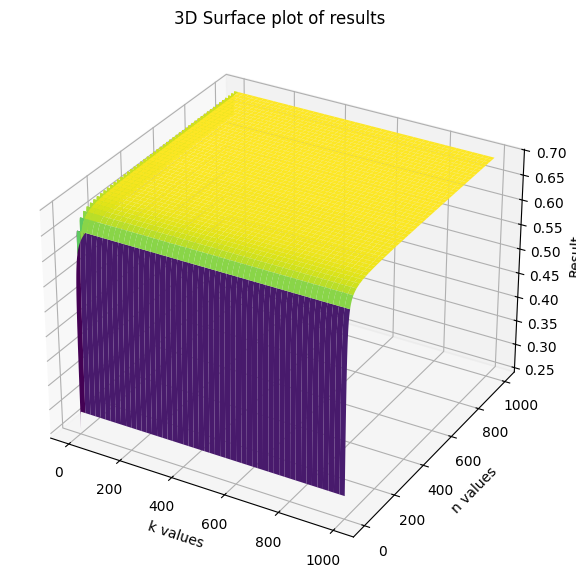

Execution time to compute the two matrices A and B for large K and N: 0.09747 seconds
Maximum value in matrix B:  0.6921486782304311


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import time

def fill_matrix(maxk, maxn):
    k = np.arange(1, maxk + 1).reshape(-1, 1)
    n = np.arange(1, maxn + 1)
    with np.errstate(divide='ignore'):
        matrix = 1 / (k * (n + 1) ** (2 * k))
        matrix[np.isinf(matrix)] = 0
    return matrix

# Compute the matrix of solutions for v(0, 0) to v(1000, 1000)
start_time = time.time()
A = fill_matrix(1000, 1000)

# Compute the matrix of solutions for S(0, 0) to S(1000, 1000)
B = A.cumsum(axis=0).cumsum(axis=1)
end_time = time.time()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
k_vals, n_vals = np.meshgrid(range(1, 1001), range(1, 1001), indexing='ij')
ax.plot_surface(k_vals, n_vals, B, cmap='viridis')

ax.set_xlabel('k values')
ax.set_ylabel('n values')
ax.set_zlabel('Result')
ax.set_title('3D Surface plot of results')

plt.show()

print(f"Execution time to compute the two matrices A and B for large K and N: {end_time - start_time:.5f} seconds")
print("Maximum value in matrix B: ", np.max(B))

Our visualization shows that matrix B defines a surface that approaches ~.7 as the values of k and n increase. Note that when filling matrix A for high(ish) values of k, the formula

  v(k,n) = 1 / (k × (n+1)²ᵏ)

produces values so close to zero that they fall below the threshold of floating point precision, throw divide-by-zero warnings, and return infinite cell values. We ignore the warnings with `np.errstate(divide='ignore')` and replace all infinite values with 0 after filling the matrix.

Note also how insanely fast this numpy matrix math is. Where it earlier took us 14 second to compute S(K, N) with iterators, we now compute the entire set of solutions from S(0, 0) to S(1000, 1000) in *under 0.04 seconds*. Holy cow!

Clearly, pre-computing both matrices is a viable approach. But with these operations running so fast, maybe it doesn't even make sense to use the storage. Plus, in practice we may not know the range of K, N values we need anyway. So let's say we want to do all our compute at runtime. How might we go about that?

To get the solution S(K, N) for any pair of values, we need to compute the whole matrix A(0, 0) to A(K, N), but from matrix B we only need the one cell B(K, N). So to find S(K, N), we can fill the entire matrix A, while for B we can limit ourselves to a single computation. Let's see how we might go about that:

In [12]:
import numpy as np
import time

def fill_matrix(maxk, maxn):
    k = np.arange(1, maxk + 1).reshape(-1, 1)
    n = np.arange(1, maxn + 1)
    with np.errstate(divide='ignore'):
        matrix = 1 / (k * (n + 1) ** (2 * k))
        matrix[np.isinf(matrix)] = 0
    return matrix

# Compute the matrix of solutions for v(0, 0) to v(1000, 1000)
start_time = time.time()
A = fill_matrix(1000, 1000)

# Get the sum of all values in the matrix A
print(np.sum(A))
end_time = time.time()

print(f"Execution time to compute matrix A and sum its values for large K and N: {end_time - start_time:.5f} seconds")

0.6921486782303173
Execution time to compute matrix A and sum its values for large K and N: 0.04552 seconds


With this approach, we are able to get S(K, N) in under 0.03 seconds. Once again, I am stunned by the speed and simplicity of `numpy` matrix math.

### Huwitz and Riemann zeta Function

There is, believe it or not, an even faster solution to this problem than the `numpy` matrix math approach. I have not studied this solution and don't yet know how it works, so I leave it here as a topic for future research. Credit to user [bouchert](https://www.codewars.com/users/bouchert) on CodeWars for this solution.

In [13]:
from scipy.special import zeta,zetac

def H_R_zeta(maxk, maxn):
    return sum((zetac(2*k)-zeta(2*k,2+maxn))/k for k in range(1,maxk+1))

start_time = time.time()
A = H_R_zeta(1000, 1000)
end_time = time.time()

print(f"Execution time to compute solution using Huwitz and Riemann zeta for large K and N: {end_time - start_time:.5f} seconds")

Execution time to compute solution using Huwitz and Riemann zeta for large K and N: 0.01378 seconds


This code runs in less than a fifth of the time required for the `numpy` approach.